#Imports

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F


#Data


In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from keras.datasets import fashion_mnist
(xtrain, ytrain), (xtest, ytest) = fashion_mnist.load_data()
var_num = 784
xtrain = np.round(xtrain / 27).astype(np.float32)
xtest = np.round(xtest / 27).astype(np.float32)
xval=xtest[8000:]
xtest=xtest[:8000]
xtrain_flat = np.reshape(xtrain, (-1,var_num))
xtest_flat = np.reshape(xtest, (-1,var_num)) 

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
import tensorflow as tf
train_size = xtrain_flat.shape[0]
batch_size = 100
train_dataset = (tf.data.Dataset.from_tensor_slices(xtrain_flat).shuffle(train_size).batch(batch_size))

In [ ]:
xval.shape

(2000, 28, 28)

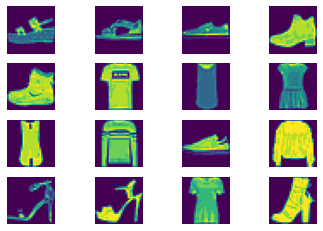

In [ ]:
def draw_grid(imlist, m, n):
  fig, grid = plt.subplots(m,n) 
  for i in range(m):
    for j in range(n):
      grid[i,j].axis('off')
      grid[i,j].imshow(np.reshape(imlist[(i-1)*m+j], (28,28)))
    
draw_grid(xtrain[:16], 4,4)

In [ ]:
def save_grid(imlist, m, n,beta,l):
  fig, grid = plt.subplots(m,n) 
  for i in range(m):
    for j in range(n):
      grid[i,j].axis('off')
      grid[i,j].imshow(np.reshape(imlist[(i-1)*m+j], (28,28)))
  fig.savefig('fig'+'beta-'+str(beta)+'latent-size'+str(l)+'.jpg')
    

In [ ]:
training_loader = DataLoader(xtrain, batch_size=32, shuffle=True)
val_loader = DataLoader(xval, batch_size=32, shuffle=False)
test_loader = DataLoader(xtest, batch_size=32, shuffle=False)

#VAE

In [ ]:
class Encoder(nn.Module):
  def __init__(self,latent_size):
    super().__init__()
    self.encoder= nn.Sequential(nn.Flatten(),nn.Linear(784, 500), nn.LeakyReLU(),
                        nn.Linear(500, 100), nn.LeakyReLU(),
                        nn.Linear(100, 2 * latent_size))
  def encode(self,x):
    e_out=self.encoder(x)
    mu,logvar=torch.chunk(e_out,2,dim=1)
    return mu,logvar
  
  def sample(self,mu,logvar):
    std = torch.exp(0.5*logvar) 
    eps = torch.randn_like(std) #using reparameterization
    return mu + std * eps
  

In [ ]:
class Decoder(nn.Module):
  def __init__(self,latent_size):
    super().__init__()
    self.decoder = nn.Sequential(nn.Linear(latent_size, 100), nn.LeakyReLU(),
                        nn.Linear(100, 500), nn.LeakyReLU(),
                        nn.Linear(500, 7840))
  def decode(self, z):
    d_out=self.decoder(z)
    d_out = d_out.view(-1, 784, 10)
    p_out = torch.softmax(d_out, 2)
    return p_out

  def sample(self,z):
    d_out=self.decode(z)
    b_size=d_out.shape[0]
    p=d_out.view(-1,10)
    out=torch.multinomial(p,num_samples=1).view(b_size,784)
    return out



In [ ]:
class VAE(nn.Module):
  def __init__(self,latent_size):
    super().__init__()
    self.encoder=Encoder(latent_size)
    self.decoder=Decoder(latent_size)
    self.prior= torch.distributions.normal.Normal(torch.zeros(latent_size), torch.ones(latent_size))

  def forward(self,x):
    EPS = 1.e-5
    mu,logvar=self.encoder.encode(x)
    z=self.encoder.sample(mu,logvar)
    d_out=self.decoder.decode(z)
    x_one_hot = F.one_hot(x.long(), 10).view(-1,784,10)
    log_p =torch.sum( x_one_hot * torch.log(torch.clamp(d_out, EPS, 1. - EPS)),-1)
    rl=log_p.sum(-1)
    kl=-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).sum(-1).sum(-1)
    return rl,kl

  def sample(self, batch_size=64):
    z = self.prior.sample_n(batch_size).to('cuda')
    return self.decoder.sample(z)

In [ ]:
D = 784 
lr = 1e-3 
num_epochs = 20

In [ ]:
def test(model,test_loader):
  rl_test,kl_test,n=0,0,0
  for i, batch in enumerate(test_loader):
    rl,kl=model.forward(batch.to('cuda'))
    rl_test+=rl.mean()
    kl_test+=kl.mean()
    n+=batch.shape[0]
  return rl_test/n,kl_test/n



In [ ]:
def samples_loss(model,test_loader):
  log_p_t,n=0,0
  for i, batch in enumerate(test_loader):
    if n+batch.shape[0]>500:
      batch=batch[:500-n]
    EPS = 1.e-5
    x=batch.to('cuda')
    mu,logvar=model.encoder.encode(x)
    z=model.encoder.sample(mu,logvar)
    d_out=model.decoder.decode(z)
    x_one_hot = F.one_hot(x.long(), 10).view(-1,784,10)
    log_p =torch.sum( x_one_hot * torch.log(torch.clamp(d_out, EPS, 1. - EPS)),-1)
    log_p_t+=log_p.sum(-1).sum(-1)
    n=n+batch.shape[0]
    if n>=500:
      break
  return log_p_t/n 

In [ ]:
def importance_sampling(model,test_loader):
  log_p_t,n=0,0
  for i, batch in enumerate(test_loader):
    if n+batch.shape[0]>500:
      batch=batch[:500-n]
    EPS = 1.e-5
    x=batch.to('cuda')
    z=model.prior.sample_n(batch.shape[0]).to('cuda')
    d_out=model.decoder.decode(z)
    x_one_hot = F.one_hot(x.long(), 10).view(-1,784,10)
    log_p =torch.sum( x_one_hot * torch.log(torch.clamp(d_out, EPS, 1. - EPS)),-1)
    log_p_t+=log_p.sum(-1).sum(-1)
    n=n+batch.shape[0]
    if n>=500:
      break
  return log_p_t/n 

In [ ]:
def run(beta,l):
  model=VAE(l).to('cuda')
  optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)
  for e in range(num_epochs):
    model.train()
    for i, batch in enumerate(training_loader):
        batch=batch.to('cuda')
        rl,kl = model.forward(batch)
        loss=-((rl-(beta*kl)).mean())
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
  test_rl,test_kl=test(model,test_loader)
  sam_loss=samples_loss(model,test_loader)
  imp_loss=importance_sampling(model,test_loader)
  print("Model with beta-",beta," and latent size-",l," : test recon loss-", test_rl.item(), " test kl-",test_kl.item(), "  500 samples log(p(x))-", sam_loss.item(), "Importance sampling",  imp_loss.item() )                      
  x = model.sample(16).to('cpu')
  x = x.detach().numpy()
  save_grid(x[:16], 3,3, beta,l)

Model with beta- 0.5  and latent size- 50  : test recon loss- -22.228181838989258  test kl- 6.625307559967041   500 samples log(p(x))- -705.3837280273438 Importance sampling -2160.273193359375
Model with beta- 0.8  and latent size- 50  : test recon loss- -23.39185333251953  test kl- 4.715831756591797   500 samples log(p(x))- -746.1939697265625 Importance sampling -2043.9732666015625
Model with beta- 1.0  and latent size- 50  : test recon loss- -23.901708602905273  test kl- 4.350164890289307   500 samples log(p(x))- -762.8460083007812 Importance sampling -1935.19580078125
Model with beta- 0.2  and latent size- 50  : test recon loss- -20.49635887145996  test kl- 10.356374740600586   500 samples log(p(x))- -652.1038818359375 Importance sampling -2434.952392578125


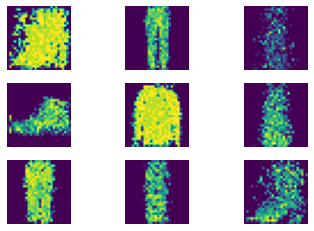

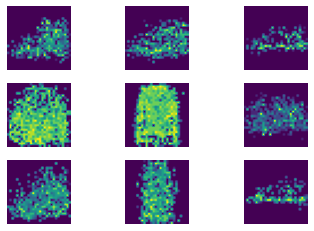

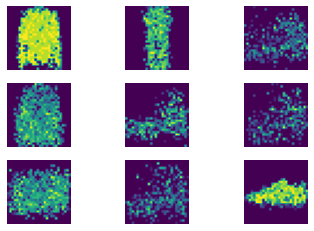

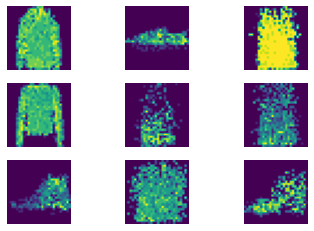

In [ ]:
for beta in [ 0.5,  0.8, 1.0,0.2]:
  for l in [50,100]:
    run(beta,l)

#NCP VAE (SAMPLE)

In [ ]:
l=50
beta=0.2

/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:166: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


Model with beta- 0.2  and latent size- 50  : test recon loss- -20.461009979248047  test kl- 10.656352043151855   500 samples log(p(x))- -652.4097290039062 Importance sampling -2394.1162109375


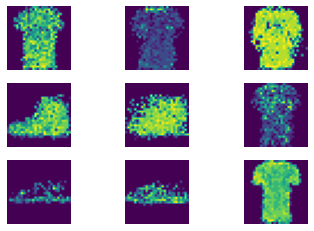

In [ ]:
model=VAE(l).to('cuda')
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)
for e in range(num_epochs):
  model.train()
  for i, batch in enumerate(training_loader):
      batch=batch.to('cuda')
      rl,kl = model.forward(batch)
      loss=-((rl-(beta*kl)).mean())
      optimizer.zero_grad()
      loss.backward(retain_graph=True)
      optimizer.step()
test_rl,test_kl=test(model,test_loader)
sam_loss=samples_loss(model,test_loader)
imp_loss=importance_sampling(model,test_loader)
print("Model with beta-",beta," and latent size-",l," : test recon loss-", test_rl.item(), " test kl-",test_kl.item(), "  500 samples log(p(x))-", sam_loss.item(), "Importance sampling",  imp_loss.item() )                      
x = model.sample(16).to('cpu')
x = x.detach().numpy()
save_grid(x[:16], 3,3, beta,l)

In [ ]:
model.eval()
z=[]
for indx_batch, batch in enumerate(training_loader):
  zm,zs=(model.encoder.encode(batch.to('cuda')))
  f=model.encoder.sample(zm,zs)
  if len(z)==0:
    z=f
  else:
    z=torch.concat((z,f))
print(len(z)) 

60000


In [ ]:
z.shape

torch.Size([60000, 50])

In [ ]:
class NCP(torch.nn.Sequential):

    def __init__(self, input_dim=50, hid_dim=100):
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        super().__init__(
            torch.nn.Linear(input_dim, hid_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(.2),
            torch.nn.Linear(hid_dim, hid_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(.2),
            torch.nn.Linear(hid_dim, 1))

    def langevin_sample(self, seed=None, n_samples=100, n_iter=200):
        if seed is not None:
            X = seed.clone().requires_grad_()
        else:
            X = torch.randn(n_samples, self.input_dim).to('cuda').requires_grad_()

        for param in self.parameters():
            param.requires_grad = False

        self.eval()
        for t in range(n_iter):
            z = self(X).sum().backward()
            eps = .1 * (10 + t) ** -1
            sigma = np.sqrt(eps)
            f=torch.randn(n_samples, self.input_dim).to('cuda')
            eta = sigma * f
            X.data -= (eps / 2) * X.grad - eta
            X.grad.zero_()

        for param in self.parameters():
            param.requires_grad = True
        return X.detach()

    def loss(self, X):
        seed = X
        X_spl = self.langevin_sample(seed=seed, n_samples=X.shape[0])
        self.train()
        print(torch.mean(self(X) - self(X_spl)))
        return torch.mean(self(X) - self(X_spl))

    def fit(self, X, n_iter=10, callback=None):
        opt = torch.optim.AdamW(lr=0.01, weight_decay=.01, params=self.parameters())
        self.train()
        for t in range(n_iter):
            print(t)
            opt.zero_grad()
            lval = self.loss(X)
            lval.backward()
            opt.step()


In [ ]:
X=z
X = (X).detach().to(dtype=torch.float32).to('cuda')
em = EnergyModel(input_dim=50).to('cuda')
em.fit(X)
zl=em.langevin_sample(n_samples=10)
print(zl.shape)

0
tensor(-0.0087, device='cuda:0', grad_fn=<MeanBackward0>)
1
tensor(-0.1093, device='cuda:0', grad_fn=<MeanBackward0>)
2
tensor(-0.2218, device='cuda:0', grad_fn=<MeanBackward0>)
3
tensor(-0.3800, device='cuda:0', grad_fn=<MeanBackward0>)
4
tensor(-0.5545, device='cuda:0', grad_fn=<MeanBackward0>)
5
tensor(-0.7453, device='cuda:0', grad_fn=<MeanBackward0>)
6
tensor(-0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
7
tensor(-1.0892, device='cuda:0', grad_fn=<MeanBackward0>)
8
tensor(-1.1235, device='cuda:0', grad_fn=<MeanBackward0>)
9
tensor(-0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([10, 50])


In [ ]:
f=model.decoder.sample(zl)

In [ ]:
f.shape

torch.Size([10, 784])

In [ ]:
f=f.to('cpu').detach().numpy()

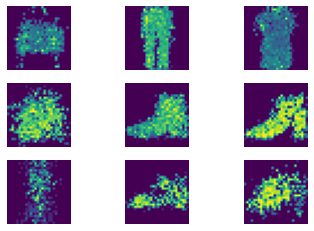

In [84]:
draw_grid(f,2,2)